In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")

# data scaling

In [3]:
from sklearn.linear_model import LinearRegression
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
X = np.column_stack((
    data_no_missing.UDel_temp_popweight,
    np.square(data_no_missing.UDel_temp_popweight),
    data_no_missing.UDel_precip_popweight,
    np.square(data_no_missing.UDel_precip_popweight)
))
Y = np.array(data_no_missing.growthWDI).reshape(-1,1)
linreg = LinearRegression().fit(X,Y)
print(linreg.coef_)
print(linreg.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]]
[0.01702781]


In [3]:
# precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
# precip_scaled = precip_scaler.fit_transform(np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1)).flatten()
# gdp_scaled = gdp_scaler.fit_transform(np.array(data_no_missing.growthWDI).reshape(-1,1)).flatten()
# temp_scaled = temp_scaler.fit_transform(np.array(data_no_missing.UDel_temp_popweight).reshape(-1,1)).flatten()

precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# year and country fixed effect coefficient matrices

In [4]:
# data_len = len(data_no_missing.year)
# year_mult_mat = [np.zeros(data_len) for year in set(data_no_missing.year)]
# country_mult_mat = [np.zeros(data_len) for country in set(data_no_missing.iso)]
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
# for row_index, row in enumerate(data_no_missing.itertuples()):
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - 1960
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [5]:
# gradual year-by-year effects
# grad_effects_data = np.transpose(np.array(data_no_missing.loc[:, data_no_missing.columns.str.startswith(('_y'))]))
grad_effects_data = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y'))]))

In [6]:
with pm.Model() as model:
    
    temp_prior = pm.Normal("temp_prior", 0, 1)
    temp_std = pm.HalfNormal("temp_std", 10)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=temp_scaled)

    precip_prior = pm.Normal("precip_prior", 0, 1)
    precip_std = pm.HalfNormal("precip_std", 10)
    precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=precip_scaled)

    gdp_intercept = pm.Normal('gdp_intercept',0,10)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,10)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,10)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,10)

    # year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data_no_missing.year)))),axis=1)
    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    # country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data_no_missing.iso)))),axis=1)
    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data.iso)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_coefs*country_mult_mat,axis=0))

    gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 5, shape=(len(grad_effects_data))),axis=1)
    gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))
    
    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        (temp_posterior * temp_gdp_coef) +
        (temp_sq_gdp_coef * pt.sqr(temp_posterior)) +
        (precip_posterior * precip_gdp_coef) +
        (precip_sq_gdp_coef * pt.sqr(precip_posterior)) +
        year_fixed_effects +
        country_fixed_effects +
        gradual_effects
    )
    
    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)

    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    # advi_fit = pm.fit(n=300000, method="advi")
    # trace = advi_fit.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [country_coefs, gdp_intercept, gdp_posterior_observed, gdp_posterior_unobserved, gdp_std, grad_effect_coefs, precip_gdp_coef, precip_posterior_observed, precip_posterior_

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5cd4928fa0>>
Traceback (most recent call last):
  File "/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
with open ('../models/burke-reproduction-mcmc-fixed-effects-grad_effects_missing-rows-imputed.pkl', 'wb') as buff:
    pkl.dump({
        "prior":prior,
        "trace":trace,
        "posterior":posterior,
        "precip_scaler":precip_scaler,
        "temp_scaler":temp_scaler,
        "gdp_scaler":gdp_scaler
    },buff)

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/tmp/ipykernel_3144/1857160435.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


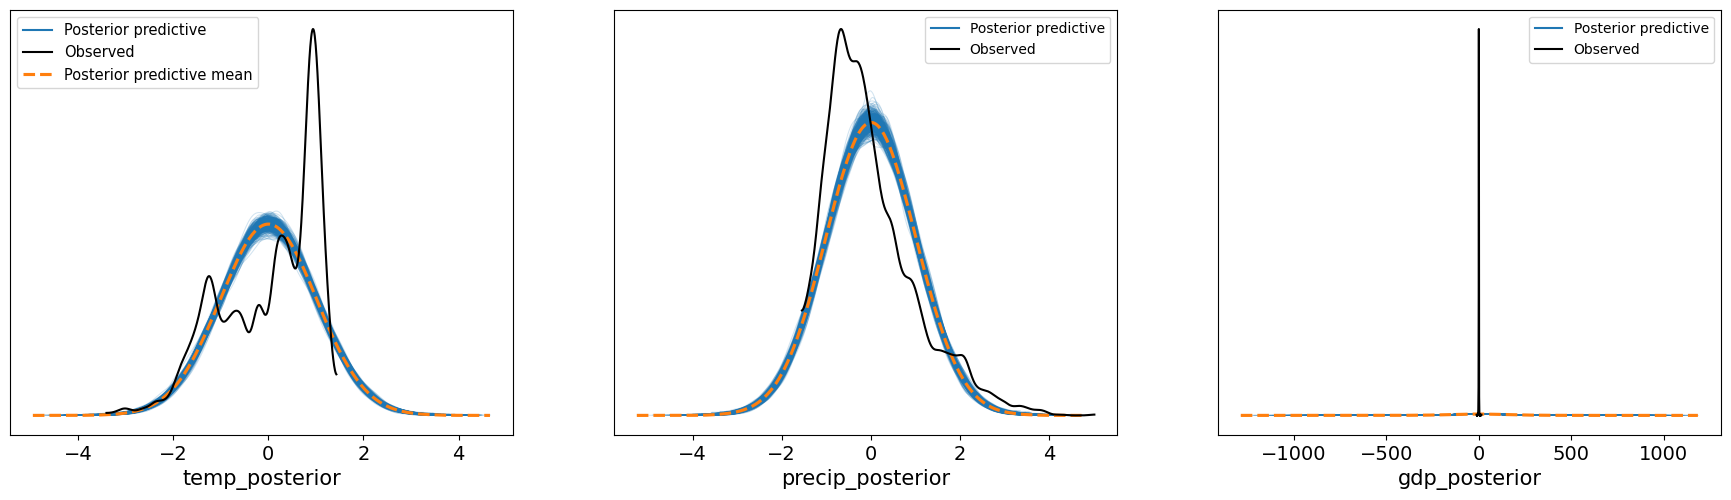

In [77]:
fig = az.plot_ppc(posterior,var_names=["temp_posterior","precip_posterior","gdp_posterior"]).ravel()[0].figure
fig.show()

/tmp/ipykernel_3144/1883471754.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


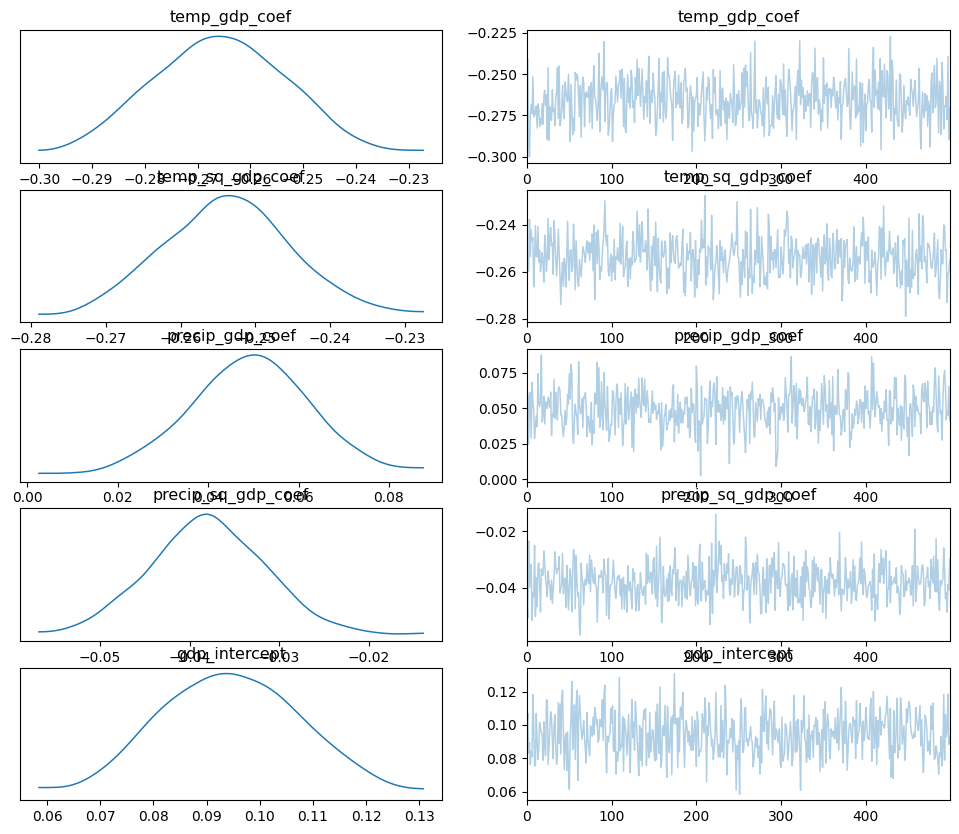

In [38]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"]).ravel()[0].figure
fig.show()

In [103]:
# model = pd.read_pickle('../models/burke-reproduction-advimeanfield300k-fixed-effects-grad_effects_missing-rows-omitted.pkl')
model = pd.read_pickle('../models/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-omitted.pkl')
trace = model["trace"]
posterior = model["posterior"]

In [70]:
print(np.mean(trace.posterior.temp_gdp_coef.data))
print(np.mean(trace.posterior.temp_sq_gdp_coef.data))
print(np.mean(trace.posterior.precip_gdp_coef.data))
print(np.mean(trace.posterior.precip_sq_gdp_coef.data))
print(np.mean(trace.posterior.gdp_intercept.data))

-0.2872678922886988
-0.11567231290828422
-0.25529381491382064
0.06662454517913959
-0.1549755242724205


# Confirm that unscaled samples lead to correct coefficients

In [104]:
precip_data = precip_scaler.inverse_transform(np.array(posterior.posterior_predictive.precip_posterior.data.flatten()).reshape(-1,1))
gdp_data = gdp_scaler.inverse_transform(np.array(posterior.posterior_predictive.gdp_posterior.data.flatten()).reshape(-1,1))
temp_data = temp_scaler.inverse_transform(np.array(posterior.posterior_predictive.temp_posterior.data.flatten()).reshape(-1,1))
X = np.column_stack((
    temp_data,
    np.square(temp_data),
    precip_data,
    np.square(precip_data)
))
linreg = LinearRegression().fit(X,gdp_data)
print(linreg.coef_)
print(linreg.intercept_)

[[ 1.37053508e-02 -4.99408924e-04  1.51364800e-05 -4.69578188e-09]]
[-0.04336398]


# Reproduce 13C threshold with probabilistic model

In [116]:
og_coef1 = linreg.coef_[0][0]
og_coef2 = linreg.coef_[0][1]
og_coef3 = linreg.coef_[0][2]
og_coef4 = linreg.coef_[0][3]
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef3 = trace.posterior.precip_gdp_coef.data.flatten()
coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
mult1 = og_coef1/np.mean(coef1)
mult2 = og_coef2/np.mean(coef2)
mult3 = og_coef3/np.mean(coef3)
mult4 = og_coef4/np.mean(coef4)
numerator = [val*mult1 for val in coef1]
denominator = [-2*val*mult2 for val in coef2]
res = np.array(numerator) / np.array(denominator)

In [111]:
print(np.mean(res), np.mean(res) - np.std(res), np.mean(res) + np.std(res))

13.762530078295098 9.451260250855231 18.073799905734965


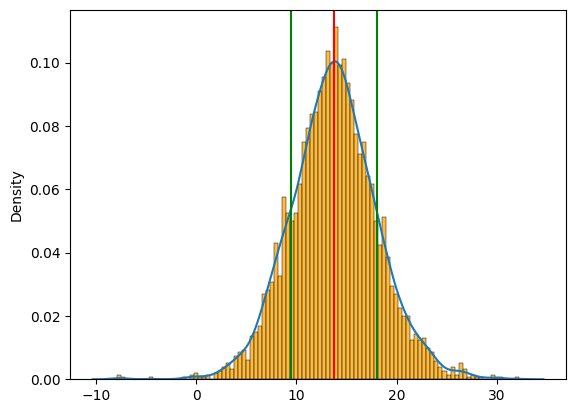

In [147]:
x = np.linspace(np.mean(res) - 3*np.std(res), np.mean(res) + 3*np.std(res), 100)
sns.histplot(res,bins=100,color="orange",stat="density")
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res)
plt.axvline(x = np.mean(res), color = 'r', label = 'axvline - full height')
plt.axvline(x = np.mean(res) - np.std(res), color = 'g', label = 'axvline - full height')
plt.axvline(x = np.mean(res) + np.std(res), color = 'g', label = 'axvline - full height')
plt.savefig("../figures/burke_reproduction_pdf.png")

# Scaled coefs for error estimation

In [117]:
print(np.mean(mult1*coef1))
print(np.std(mult1*coef1))
print(np.mean(mult2*coef2))
print(np.std(mult2*coef2))
print(np.mean(mult3*coef3))
print(np.std(mult3*coef3))
print(np.mean(mult4*coef4))
print(np.std(mult4*coef4))

0.013705350763949894
0.0047443907078334605
-0.0004994089237706799
9.936365151471116e-05
1.5136479961682805e-05
1.9234727776221966e-05
-4.695781879277775e-09
2.4980142656251447e-09


# Burke et al. Uncertainty Bounds

In [120]:
burke_temp_coef = .0127183
burke_temp2_coef = -.0004871
burke_temp_error = .0037876
burke_temp2_error = .0001184

lower_bound = (burke_temp_coef - burke_temp_error ) / (-2 * (burke_temp2_coef - burke_temp2_error))
upper_bound = (burke_temp_coef + burke_temp_error ) / (-2 * (burke_temp2_coef + burke_temp2_error))
mean = burke_temp_coef / (-2 * burke_temp2_coef)
print(lower_bound)
print(upper_bound)
print(mean)

7.374649050371593
22.383916463249253
13.05512215150893
